In this assignment, all the 4 distances discussed in YASS Stemmer paper have been implemented for stemming. For determining the efficiency of these approaches, MAP score has been calculated. For comparison, MAP score using Levenshtein distance, Word2Vec stemming and Porter Stemmer have also been calculated. 

After collecting the data in proper formats, acquiring a proper threshold for clustering was required. For that, different thresholds were taken and agglomerative clustering with complete linkage was used. Then graphs were plotted for picking the most optimal value of threshold. 

For clustering, Agglomerative clustering is used with average linkage. And then dictionary is made consisting of (word, stem) pair. This dictionary is made for all the distances and then the respective dictionaries are used for stemming of data and queries. And after performing stemming this way, MAP scores are calculated using PyTerrier.

The MAP scores obtained are as follows. 

1.   Distance D1 - 0.350961
2.   Distance D2 - 0.368940
3.   Distance D3 - 0.359912
4.   Distance D4 - 0.360361
5.   Levenshtein - 0.358361
6.   --Word2Vec- - 0.202755
7.  -----Porter----- - 0.356276

**Downloading the dataset**

In [ ]:
!gdown --id 1JuawXQmYVkjpfL3H0blqjDrqw8V1lHrC

Downloading...
From: https://drive.google.com/uc?id=1JuawXQmYVkjpfL3H0blqjDrqw8V1lHrC
To: /content/FIRE_Dataset_EN_2010.rar
133MB [00:02, 56.0MB/s]


**Extracting the dataset**

In [ ]:
!unrar x -y FIRE_Dataset_EN_2010.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from FIRE_Dataset_EN_2010.rar

Creating    FIRE_Dataset_EN_2010                                      OK
Extracting  FIRE_Dataset_EN_2010/en.qrels.76-125.2010.txt.gz               0%  OK 
Extracting  FIRE_Dataset_EN_2010/en.topics.76-125.2010.txt                 0%  OK 
Extracting  FIRE_Dataset_EN_2010/English-Data.tgz                          3%  6%  9% 12% 15% 19% 22% 25% 28% 31% 34% 37% 41% 44% 47% 50% 53% 56% 60% 63% 66% 69% 72% 75% 78% 82% 85% 88% 91% 94% 97% 99%  OK 
All OK


In [ ]:
!tar -xvzf FIRE_Dataset_EN_2010/English-Data.tgz

Streaming output truncated to the last 5000 lines.
TELEGRAPH_UTF8/2007_utf8/sports/1070225_sports_story_7438352.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070621_sports_story_7952331.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070207_sports_story_7360730.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070919_sports_story_8334184.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070218_sports_story_7407969.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070317_sports_story_7529504.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070411_sports_story_7632626.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070507_sports_story_7743729.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070318_sports_story_7533511.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070625_sports_story_7969700.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070521_sports_story_7807303.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070517_sports_story_7787900.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070814_sports_story_8191386.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070908_sports_story_8291527.utf8
TELEGRAPH_UTF8/2007_utf8/

In [ ]:
!gzip -d FIRE_Dataset_EN_2010/en.qrels.76-125.2010.txt.gz

**Importing necessary libraries and packages**

In [ ]:
import numpy as np
import os
import glob
from bs4 import BeautifulSoup
import lxml.html
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from nltk.corpus import brown
import bisect
import xml.etree.ElementTree as ET
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

**Installing and importing PyTerrier**

In [ ]:
!pip install python-terrier
import pyterrier as pt
if not pt.started():
    pt.init()

# Storing the brown corpus in proper format
Brown corpus is later used when plotting the number of clusters vs threshold graphs for various distances and Word2Vec stemmer. 

In [ ]:
train_data = brown.words(categories='news')
train_data = np.unique(train_data)

In [ ]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

# Removing non-alphabetic text and Converting text to lower-case
words = [word.lower() for word in train_data if word.isalpha()]
# Removing stopwords
words = [w for w in words if not w in stop_words]
# Performing lemmatization
train_data = [lemmatizer.lemmatize(word) for word in words]

# Functions for the D1, D2, D3, D4 and Levenshtein Distances

In [ ]:
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])


def distance1(seq1, seq2):
    size_x = len(seq1)
    size_y = len(seq2)

    max_size = max(size_x, size_y)
    min_size = min(size_x, size_y)

    p = [1]*max_size
    
    for i in range(max_size):
        if(i < min_size and seq1[i]==seq2[i]):
            p[i] = 0
    
    d = 0
    for i in range(len(p)):
        d = d + ((1/2**i)*p[i])
    return d

def distance2(seq1, seq2):
    size_x = len(seq1)
    size_y = len(seq2)

    max_size = max(size_x, size_y)
    min_size = min(size_x, size_y)

    m = min_size

    for i in range(max_size):
        if(i < min_size and seq1[i]!=seq2[i]):
            m = i
            break

    if m == 0: 
        return 10000

    d = 0
    for i in range(m, max_size):
        d = d + ((1/2**(i-m)))
    
    return d*(1/m)

def distance3(seq1, seq2):
    size_x = len(seq1)
    size_y = len(seq2)

    max_size = max(size_x, size_y)
    min_size = min(size_x, size_y)

    m = min_size

    for i in range(max_size):
        if(i < min_size and seq1[i]!=seq2[i]):
            m = i
            break

    if m == 0: 
        return 10000

    d = 0
    for i in range(m, max_size):
        d = d + ((1/2**(i-m)))
    
    return d*((max_size-m+1)/m)

def distance4(seq1, seq2):
    size_x = len(seq1)
    size_y = len(seq2)

    max_size = max(size_x, size_y)
    min_size = min(size_x, size_y)

    m = min_size

    for i in range(max_size):
        if(i < min_size and seq1[i]!=seq2[i]):
            m = i
            break

    d = 0
    for i in range(m, max_size):
        d = d + ((1/2**(i-m)))
    
    return d*((max_size-m+1)/(max_size+1))


# Distance Matrices for five distances to be used for plotting graphs and later determining the threshold

In [ ]:
size = 1000

lv = [[0 for i in range(size)] for j in range(size)]
d1 = [[0 for i in range(size)] for j in range(size)] 
d2 = [[0 for i in range(size)] for j in range(size)] 
d3 = [[0 for i in range(size)] for j in range(size)] 
d4 = [[0 for i in range(size)] for j in range(size)] 

print("Calculating Levenshtein, D1, D2, D3, D4 based distances...")
count = 0
for i in range(size) : 
  for j in range(size) : 
    lv[i][j] = levenshtein(train_data[i], train_data[j])
    d1[i][j] = distance1(train_data[i], train_data[j])
    d2[i][j] = distance2(train_data[i], train_data[j])
    d3[i][j] = distance3(train_data[i], train_data[j])
    d4[i][j] = distance4(train_data[i], train_data[j])
  count = count + 1
  if count%100==0:
    print("Progress: ", count, " / ", size)

Calculating Levenshtein, D1, D2, D3, D4 based distances...
Progress:  100  /  1000
Progress:  200  /  1000
Progress:  300  /  1000
Progress:  400  /  1000
Progress:  500  /  1000
Progress:  600  /  1000
Progress:  700  /  1000
Progress:  800  /  1000
Progress:  900  /  1000
Progress:  1000  /  1000


# Plotting the number of clusters vs threshold

In this section, we perform Aglomerative clustering for obtaining number of clusters for a particular threshold value for all the five distances.

Clustering based on Levenshtein Distance


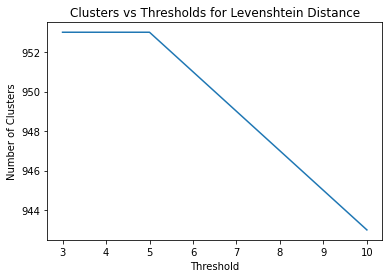

Clustering based on D1


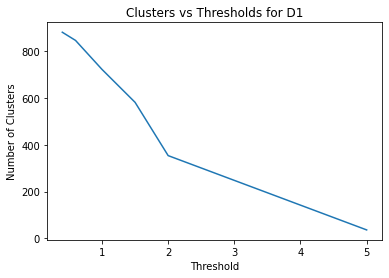

Clustering based on D2


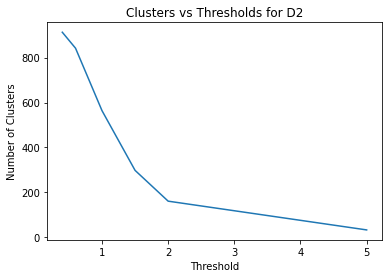

Clustering based on D3


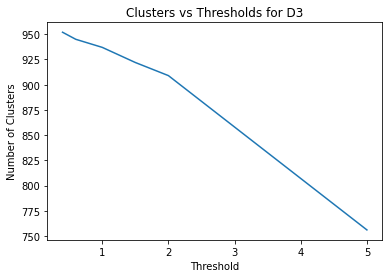

Clustering based on D4


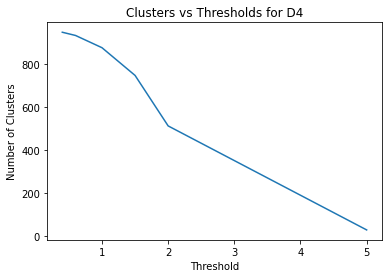

In [ ]:
thresholds = [3, 4, 4.5, 5, 6, 10]
print("Clustering based on Levenshtein Distance")
n_clusters = []
for threshold in thresholds:
    d_clustering = AgglomerativeClustering(linkage = 'complete', distance_threshold = threshold, n_clusters = None).fit(lv)
    n_clusters.append(d_clustering.n_clusters_)

plt.plot(thresholds, n_clusters)   
plt.xlabel('Threshold') 
plt.ylabel('Number of Clusters')   
plt.title('Clusters vs Thresholds for Levenshtein Distance') 
plt.show()

thresholds = [0.4, 0.6, 1, 1.5, 2, 5]
print("Clustering based on D1")
n_clusters = []
for threshold in thresholds:
    d_clustering = AgglomerativeClustering(linkage = 'complete', distance_threshold = threshold, n_clusters = None).fit(d1)
    n_clusters.append(d_clustering.n_clusters_)

plt.plot(thresholds, n_clusters)   
plt.xlabel('Threshold') 
plt.ylabel('Number of Clusters')   
plt.title('Clusters vs Thresholds for D1') 
plt.show()


print("Clustering based on D2")
n_clusters = []
for threshold in thresholds:
    d_clustering = AgglomerativeClustering(linkage = 'complete', distance_threshold = threshold, n_clusters = None).fit(d2)
    n_clusters.append(d_clustering.n_clusters_)

plt.plot(thresholds, n_clusters)   
plt.xlabel('Threshold') 
plt.ylabel('Number of Clusters')   
plt.title('Clusters vs Thresholds for D2') 
plt.show()

print("Clustering based on D3")
n_clusters = []
for threshold in thresholds:
    d_clustering = AgglomerativeClustering(linkage = 'complete', distance_threshold = threshold, n_clusters = None).fit(d3)
    n_clusters.append(d_clustering.n_clusters_)

plt.plot(thresholds, n_clusters)   
plt.xlabel('Threshold') 
plt.ylabel('Number of Clusters')   
plt.title('Clusters vs Thresholds for D3') 
plt.show()


print("Clustering based on D4")
n_clusters = []
for threshold in thresholds:
    d_clustering = AgglomerativeClustering(linkage = 'complete', distance_threshold = threshold, n_clusters = None).fit(d4)
    n_clusters.append(d_clustering.n_clusters_)

plt.plot(thresholds, n_clusters)   
plt.xlabel('Threshold') 
plt.ylabel('Number of Clusters')   
plt.title('Clusters vs Thresholds for D4') 
plt.show()

# Preprocessing on FIRE Dataset

In this section, basic preprocessing steps are performed on data of FIRE dataset. Data is then stored in proper formats. Also, dataframe for porterstemmer is generated in this step and later used in the end.

In [ ]:
files = [] # List is storing file name and file content. File content is a list of words.
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~''' 
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
pcorpus = []
pfname = []
print("Collecting data from files of FIRE dataset.")
i = 0
for subdir, dirs, filenames in os.walk('TELEGRAPH_UTF8/'):
    for file_obj in filenames:
      i = i+1
      filename = os.path.join(subdir, file_obj)
      # Extracting data and saving it to raw_text
      soup = BeautifulSoup(open(filename, "r").read())
      raw_text = soup.find('text').get_text()
      for sym in raw_text : 
        # Removing punctuation
        if sym in punc : 
          raw_text = raw_text.replace(sym, "")

      # Removing non-alphabetic text and Converting text to lower-case
      words = [word.lower() for word in raw_text.split() if word.isalpha()]
      # Removing stopwords
      words = [w for w in words if not w in stop_words]
      temp_file = []
      # Storing filename to list
      temp_file.append(str(file_obj))
      # Storing file data to list
      temp_file.append(words)
      # Appending data to 'files' list
      files.append(temp_file)

      pstemmed = [porter.stem(word) for word in words]
      pstemmed = ' '.join([str(word) for word in pstemmed])
      if pstemmed != '':
        pcorpus.append(pstemmed)
        pfname.append(str(file_obj))

print("Preprocessing on data done.")
print("Total Documents: ", len(files))

print("Storing this data for performing various stemming methods later.")
temp_terms = []
i = 0
for curr_file in files : 
  for word in curr_file[1]:
    temp_terms.append(word)
  i = i + 1
  if(i%10000==0): print("Progress: ", i, " / ", len(files), "   Total Words: ", len(temp_terms))
print("Data stored properly for further usage.")
# Converting set to sorted list
dataset = sorted(list(set(temp_terms)))
print("\n")
print("Making dataframe for stemmed words using Porter Stemmer (for later usage)")
df_data_ps = pd.DataFrame({'docno': pfname, 'text': pcorpus})
del temp_terms

Preprocessing on data done.
Total Documents:  125586
Storing this data for performing various stemming methods later.
Progress:  10000  /  125586    Total Words:  2585461
Progress:  20000  /  125586    Total Words:  5204165
Progress:  30000  /  125586    Total Words:  7037242
Progress:  40000  /  125586    Total Words:  9033664
Progress:  50000  /  125586    Total Words:  12320028
Progress:  60000  /  125586    Total Words:  14547687
Progress:  70000  /  125586    Total Words:  16387413
Progress:  80000  /  125586    Total Words:  18725383
Progress:  90000  /  125586    Total Words:  21292751
Progress:  100000  /  125586    Total Words:  24437174
Progress:  110000  /  125586    Total Words:  26368325
Progress:  120000  /  125586    Total Words:  28233348
Data stored properly for further usage.


Making dataframe for stemmed words using Porter Stemmer (for later usage)


In [ ]:
train_data = sorted(train_data)

# Functions for making clusters and making stems on data

This section contains to functions. One is for making clusters on the basis of dataset, linkage type in Agglomerative clustering, threshold value and distance type (out of 5 discussed in the YASS paper). 

The clustering is performed in 500x500 batches on the dataset that is sorted.

The other one is for making stems which uses labels and number of clusters produced in the above function ans returns stems of the dataset.

In [ ]:
def make_clusters(dataset, linkage_type, threshold, typ) :

  d2 = []
  dataset_labels = []
  total_clusters = 0
  last_count = 0
  fname = []

  count = 0
  for i in range(len(dataset)) : 
    d = []
    for j in range(last_count, min(last_count+500, len(dataset))) : 
      if typ == 1:
        d.append(distance1(dataset[i], dataset[j]))
      elif typ == 2:
        d.append(distance2(dataset[i], dataset[j]))
      elif typ == 3:
        d.append(distance3(dataset[i], dataset[j]))
      elif typ == 4:
        d.append(distance4(dataset[i], dataset[j]))
      elif typ == 5:
        d.append(levenshtein(dataset[i],dataset[j]))
    d2.append(d)
    
    count = count + 1
    if count%500==0:
      last_count = count

      d_clustering = AgglomerativeClustering(linkage = linkage_type, distance_threshold = threshold, n_clusters = None).fit(d2)
      labels = d_clustering.labels_
      num_clusters = d_clustering.n_clusters_
      
      new_labels = [x+total_clusters for x in labels]
      dataset_labels.extend(new_labels)

      total_clusters = total_clusters + num_clusters
      d2.clear()

  return dataset_labels, total_clusters

def make_stems(dataset_labels, total_clusters):
    td = {}

    for i in range(len(dataset_labels)):
      if dataset_labels[i] in td.keys():
          td[dataset_labels[i]].append(i)
      else:
          td[dataset_labels[i]] = [i]

    stems = []

    count = 0
    for i in range(total_clusters):
        min_size = 100
        stem = None
        for value in td[i]:
          if(len(dataset[value]) < min_size):
              min_size = len(dataset[value])
              stem = dataset[value]
        stems.append(stem)
    return stems

# Performing stemming and generating dataframes

In this section, both the functions declared above are used. And then stemming is performed on the dataset and the data is stored in pandas dataframes for five distances D1, D2, D3, D4, and Lv. This is to be used for feeding to Terrier for MAP score.

In [ ]:
print("Clustering using D1 started...")
dataset_labels_d1, total_clusters_d1 = make_clusters(dataset, "average", 1.0, 1)
print("Clustering using D1 done.")
print("Stemming using D1 started...")
stems_d1 = make_stems(dataset_labels_d1, total_clusters_d1)

fname = []
files_temp = []

for curr_file in files : 
  file_words = []
  for word in curr_file[1]:
    try: 
      stem_word = stems_d1[dataset_labels_d1[bisect.bisect_left(dataset, word)]]
      file_words.append(stem_word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  if file_words != '':
    files_temp.append(file_words)
    fname.append(str(curr_file[0]))

print("Stemming using D1 done.")
df_data_d1 = pd.DataFrame({'docno': fname, 'text': files_temp})
del files_temp
del fname

print("=======================================================================")

print("Clustering using D2 started...")
dataset_labels_d2, total_clusters_d2 = make_clusters(dataset, "average", 1.0, 2)
print("Clustering using D2 done.")
print("Stemming using D2 started...")
stems_d2 = make_stems(dataset_labels_d2, total_clusters_d2)

fname = []
files_temp = []

for curr_file in files : 
  file_words = []
  for word in curr_file[1]:
    try: 
      stem_word = stems_d2[dataset_labels_d2[bisect.bisect_left(dataset, word)]]
      file_words.append(stem_word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  if file_words != '':
    files_temp.append(file_words)
    fname.append(str(curr_file[0]))

print("Stemming using D2 done.")
df_data_d2 = pd.DataFrame({'docno': fname, 'text': files_temp})
del files_temp
del fname

print("=======================================================================")

print("Clustering using D3 started...")
dataset_labels_d3, total_clusters_d3 = make_clusters(dataset, "average", 0.7, 3)
print("Clustering using D3 done.")
print("Stemming using D3 started...")
stems_d3 = make_stems(dataset_labels_d3, total_clusters_d3)

fname = []
files_temp = []

for curr_file in files : 
  file_words = []
  for word in curr_file[1]:
    try: 
      stem_word = stems_d3[dataset_labels_d3[bisect.bisect_left(dataset, word)]]
      file_words.append(stem_word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  if file_words != '':
    files_temp.append(file_words)
    fname.append(str(curr_file[0]))

print("Stemming using D3 done.")
df_data_d3 = pd.DataFrame({'docno': fname, 'text': files_temp})
del files_temp
del fname

print("=======================================================================")

print("Clustering using D4 started...")
dataset_labels_d4, total_clusters_d4 = make_clusters(dataset, "average", 1.0, 4)
print("Clustering using D4 done.")
print("Stemming using D4 started...")
stems_d4 = make_stems(dataset_labels_d4, total_clusters_d4)

fname = []
files_temp = []

for curr_file in files : 
  file_words = []
  for word in curr_file[1]:
    try: 
      stem_word = stems_d4[dataset_labels_d4[bisect.bisect_left(dataset, word)]]
      file_words.append(stem_word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  if file_words != '':
    files_temp.append(file_words)
    fname.append(str(curr_file[0]))

print("Stemming using D4 done.")
df_data_d4 = pd.DataFrame({'docno': fname, 'text': files_temp})
del files_temp
del fname

print("=======================================================================")

print("Clustering using Levenshtein started...")
dataset_labels_lv, total_clusters_lv = make_clusters(dataset, "average", 1.0, 3)
print("Clustering using Levenshtein done.")
print("Stemming using Levenshtein started...")
stems_lv = make_stems(dataset_labels_lv, total_clusters_lv)

fname = []
files_temp = []

for curr_file in files : 
  file_words = []
  for word in curr_file[1]:
    try: 
      stem_word = stems_lv[dataset_labels_lv[bisect.bisect_left(dataset, word)]]
      file_words.append(stem_word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  if file_words != '':
    files_temp.append(file_words)
    fname.append(str(curr_file[0]))

print("Stemming using Levenshtein done.")
df_data_lv = pd.DataFrame({'docno': fname, 'text': files_temp})
del files_temp
del fname

Clustering using D1 started...
Clustering using D1 done.
Stemming using D1 started...
Stemming using D1 done.
Clustering using D2 started...
Clustering using D2 done.
Stemming using D2 started...
Stemming using D2 done.
Clustering using D3 started...
Clustering using D3 done.
Stemming using D3 started...
Stemming using D3 done.
Clustering using D4 started...
Clustering using D4 done.
Stemming using D4 started...
Stemming using D4 done.
Clustering using Levenshtein started...
Clustering using Levenshtein done.
Stemming using Levenshtein started...
Stemming using Levenshtein done.


# Extracting and Preprocessing on Queries

In [ ]:
queryPath = "FIRE_Dataset_EN_2010/en.topics.76-125.2010.txt"
tree = ET.parse(queryPath)
root = tree.getroot()
q_pcorpus = []
q_pfname = []
queries = []

print("Collecting queries")
# Collecting Queries
for records in root.findall('top'):
    summary = records.find('num').text
    full = records.find('title').text

    words = [word.lower() for word in full.split() if word.isalpha()]
    # Removing stopwords
    words = [w for w in words if not w in stop_words]
    queries.append([summary, words])
    q_pstemmed = [porter.stem(word) for word in words]
    q_pstemmed = ' '.join([str(word) for word in q_pstemmed])
    if q_pstemmed != '':
      q_pcorpus.append(q_pstemmed)
      q_pfname.append(str(summary))
print("Queries Collected")
print("\n")
print("Making dataframe for stemmed queries using PorterStemmer (for later usage).")
df_queries_ps = pd.DataFrame({'qid':q_pfname, 'query':q_pcorpus})

Queries Collected


Making dataframe for stemmed queries using PorterStemmer (for later usage).


# Stemming on Queries using stems generated above

In [ ]:
print("Stemming on Queries using D1")

files_temp = []
qno = []

for curr_file in queries : 
  file_words = []
  for word in curr_file[1]:
    try: 
      if word in dataset:
        stem_word = stems_d1[dataset_labels_d1[bisect.bisect_left(dataset, word)]]
        file_words.append(stem_word)
      else:
        file_words.append(word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  files_temp.append(file_words)
  qno.append(curr_file[0])

df_queries_d1 = pd.DataFrame({'qid':qno, 'query':files_temp})
del files_temp
del qno

print("=======================================================================")

print("Stemming on Queries using D2")
files_temp = []
qno = []

for curr_file in queries : 
  file_words = []
  for word in curr_file[1]:
    try: 
      if word in dataset :
        stem_word = stems_d2[dataset_labels_d2[bisect.bisect_left(dataset, word)]]
        file_words.append(stem_word)
      else:
        file_words.append(word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  files_temp.append(file_words)
  qno.append(curr_file[0])

df_queries_d2 = pd.DataFrame({'qid':qno, 'query':files_temp})
del files_temp
del qno

print("=======================================================================")

print("Stemming on Queries using D3")
files_temp = []
qno = []

for curr_file in queries : 
  file_words = []
  for word in curr_file[1]:
    try: 
      if word in dataset :
        stem_word = stems_d3[dataset_labels_d3[bisect.bisect_left(dataset, word)]]
        file_words.append(stem_word)
      else:
        file_words.append(word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  files_temp.append(file_words)
  qno.append(curr_file[0])

df_queries_d3 = pd.DataFrame({'qid':qno, 'query':files_temp})
del files_temp
del qno

print("=======================================================================")

print("Stemming on Queries using D4")
files_temp = []
qno = []

for curr_file in queries : 
  file_words = []
  for word in curr_file[1]:
    try: 
      if word in dataset :
        stem_word = stems_d4[dataset_labels_d4[bisect.bisect_left(dataset, word)]]
        file_words.append(stem_word)
      else:
        file_words.append(word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  files_temp.append(file_words)
  qno.append(curr_file[0])

df_queries_d4 = pd.DataFrame({'qid':qno, 'query':files_temp})
del files_temp
del qno

print("=======================================================================")

print("Stemming on Queries using Levenshtein")
files_temp = []
qno = []

for curr_file in queries : 
  file_words = []
  for word in curr_file[1]:
    try: 
      if word in dataset :
        stem_word = stems_lv[dataset_labels_lv[bisect.bisect_left(dataset, word)]]
        file_words.append(stem_word)
      else:
        file_words.append(word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  files_temp.append(file_words)
  qno.append(curr_file[0])

df_queries_lv = pd.DataFrame({'qid':qno, 'query':files_temp})
del files_temp
del qno

Stemming on Queries using D1
Stemming on Queries using D2
Stemming on Queries using D3
Stemming on Queries using D4
Stemming on Queries using Levenshtein


In [ ]:
qrels = pt.io.read_qrels('FIRE_Dataset_EN_2010/en.qrels.76-125.2010.txt')

# MAP scores using Terrier for D1, D2, D3, D4, and Levenshtein

In [ ]:
print("MAP Score using D1 with average linkage")
!rm -rf ./pd_index
pd_indexer_d1 = pt.DFIndexer("./pd_index")
indexref_d1 = pd_indexer_d1.index(df_data_d1["text"], df_data_d1["docno"])
del pd_indexer_d1
batchRetrieval_d1 = [pt.BatchRetrieve(indexref_d1, wmodel='TF_IDF')]
pt.Experiment(batchRetrieval_d1, df_queries_d1, qrels, ['map'])

MAP Score using D1 with average linkage


,name,map
0,BR(TF_IDF),0.350961


In [ ]:
print("MAP Score using D2 with average linkage")
!rm -rf ./pd_index
pd_indexer_d2 = pt.DFIndexer("./pd_index")
indexref_d2 = pd_indexer_d2.index(df_data_d2["text"], df_data_d2["docno"])
del pd_indexer_d2
batchRetrieval_d2 = [pt.BatchRetrieve(indexref_d2, wmodel='TF_IDF')]
pt.Experiment(batchRetrieval_d2, df_queries_d2, qrels, ['map'])

MAP Score using D2 with average linkage


,name,map
0,BR(TF_IDF),0.36894


In [ ]:
print("MAP Score using D3 with average linkage")
!rm -rf ./pd_index
pd_indexer_d3 = pt.DFIndexer("./pd_index")
indexref_d3 = pd_indexer_d3.index(df_data_d3["text"], df_data_d3["docno"])
del pd_indexer_d3
batchRetrieval_d3 = [pt.BatchRetrieve(indexref_d3, wmodel='TF_IDF')]
pt.Experiment(batchRetrieval_d3, df_queries_d3, qrels, ['map'])

MAP Score using D3 with average linkage


,name,map
0,BR(TF_IDF),0.359912


In [ ]:
print("MAP Score using D4 with average linkage")
!rm -rf ./pd_index
pd_indexer_d4 = pt.DFIndexer("./pd_index")
indexref_d4 = pd_indexer_d4.index(df_data_d4["text"], df_data_d4["docno"])
del pd_indexer_d4
batchRetrieval_d4 = [pt.BatchRetrieve(indexref_d4, wmodel='TF_IDF')]
pt.Experiment(batchRetrieval_d4, df_queries_d4, qrels, ['map'])

MAP Score using D4 with average linkage


,name,map
0,BR(TF_IDF),0.360361


In [ ]:
print("MAP Score using Levenshtein with average linkage")
!rm -rf ./pd_index
pd_indexer_lv = pt.DFIndexer("./pd_index")
indexref_lv = pd_indexer_lv.index(df_data_lv["text"], df_data_lv["docno"])
del pd_indexer_lv
batchRetrieval_lv = [pt.BatchRetrieve(indexref_lv, wmodel='TF_IDF')]
pt.Experiment(batchRetrieval_lv, df_queries_lv, qrels, ['map'])

MAP Score using Levenshtein with average linkage


,name,map
0,BR(TF_IDF),0.358361


# Storing Data for Gensim Word2Vec model training

In [ ]:
print("Storing data in corpus for Word2Vec model training.")
corpus = []
i = 0
for curr_file in files : 
  corpus.append(curr_file[1])
  i = i + 1
  if(i%10000==0): print("Progress: ", i, " / ", len(files), "   Total Words: ", len(corpus))
print("Data storage completed properly.")

Storing data in corpus for Word2Vec model training.
Progress:  10000  /  125586    Total Words:  10000
Progress:  20000  /  125586    Total Words:  20000
Progress:  30000  /  125586    Total Words:  30000
Progress:  40000  /  125586    Total Words:  40000
Progress:  50000  /  125586    Total Words:  50000
Progress:  60000  /  125586    Total Words:  60000
Progress:  70000  /  125586    Total Words:  70000
Progress:  80000  /  125586    Total Words:  80000
Progress:  90000  /  125586    Total Words:  90000
Progress:  100000  /  125586    Total Words:  100000
Progress:  110000  /  125586    Total Words:  110000
Progress:  120000  /  125586    Total Words:  120000
Data storage completed properly.


# Training Word2Vec model with CBOW approach

In [ ]:
from gensim.models import Word2Vec

vect_size = 100

print("Training with CBOW started...")
# Training Word2Vec model using CBOW 
cbow_model = Word2Vec(corpus, size = vect_size, min_count = 2,window = 10, sg = 0, hs = 1, iter = 5, workers = 10)

print("Training with CBOW done.")

Training with CBOW started...
Training with CBOW done.


# Storing data in proper format for generating stems using Word2Vec vectors

In [ ]:
print("Storing data in corpus for stemming using Word2Vec")
temp_corpus = []
for i in range(len(corpus)):
  for j in range(len(corpus[i])):
    temp_corpus.append(corpus[i][j])
corpus = sorted(list(set(temp_corpus)))
del temp_corpus
print("Storage of data completed properly.")

Storing data in corpus for stemming using Word2Vec
Storage of data completed properly.


# Generating the clusters vs threshold graph for Word2Vec to determine threshold

Calculating Word2Vec based distances...
Progress:  100  /  1000
Progress:  200  /  1000
Progress:  300  /  1000
Progress:  400  /  1000
Progress:  500  /  1000
Clustering based on Word2Vec Distance


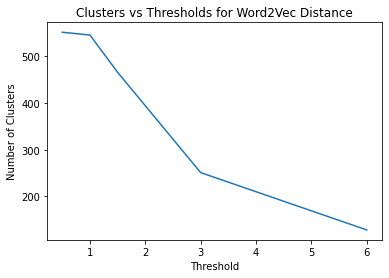

In [ ]:
size = 1000
w2v = []

print("Calculating Word2Vec based distances...")
count = 0
for i in range(size) : 
  try:
    w2v.append(cbow_model.wv.__getitem__(corpus[i]))
    count = count + 1
    if count%100==0:
      print("Progress: ", count, " / ", size)
  except:
    continue

thresholds = [0.5, 1, 1.5, 3, 6]
print("Clustering based on Word2Vec Distance")
n_clusters = []
for threshold in thresholds:
    wv_clustering = AgglomerativeClustering(linkage = 'complete', distance_threshold = threshold, n_clusters = None).fit(w2v)
    n_clusters.append(wv_clustering.n_clusters_)

plt.plot(thresholds, n_clusters)   
plt.xlabel('Threshold') 
plt.ylabel('Number of Clusters')   
plt.title('Clusters vs Thresholds for Word2Vec Distance') 
plt.show()


# Clustering and Stemming on FIRE dataset using Word2Vec vectors and Agglomerative Clustering with average linkage

In [ ]:
print("Clustering using Word2Vec started...")

d2 = []
dataset_labels_wv = []
total_clusters_wv = 0
last_count = 0
fname = []

count = 0
for i in range(len(corpus)) : 
  try:
    d2.append(cbow_model.wv.__getitem__(corpus[i]))
    count = count + 1
  except:
    continue
  if count%500==0:
    last_count = count
    d_clustering = AgglomerativeClustering(linkage = "average", distance_threshold = 0.7, n_clusters = None).fit(d2)
    labels = d_clustering.labels_
    num_clusters = d_clustering.n_clusters_
    new_labels = [x+total_clusters_wv for x in labels]
    dataset_labels_wv.extend(new_labels)
    total_clusters_wv = total_clusters_wv + num_clusters
    d2.clear()

print("Clustering using Word2Vec done.")
print("Stemming using Word2Vec started...")
stems_wv = make_stems(dataset_labels_wv, total_clusters_wv)

fname = []
files_temp = []

for curr_file in files : 
  file_words = []
  for word in curr_file[1]:
    try: 
      stem_word = stems_wv[dataset_labels_wv[bisect.bisect_left(corpus, word)]]
      file_words.append(stem_word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  if file_words != '':
    files_temp.append(file_words)
    fname.append(str(curr_file[0]))

print("Stemming using Word2Vec done.")
df_data_wv = pd.DataFrame({'docno': fname, 'text': files_temp})
del files_temp
del fname

Clustering using Word2Vec started...
Clustering using Word2Vec done.
Stemming using Word2Vec started...
Stemming using Word2Vec done.


# Stemming on Queries using stems generated above

In [ ]:
print("Stemming on Queries using Word2Vec")
files_temp = []
qno = []

for curr_file in queries : 
  file_words = []
  for word in curr_file[1]:
    try: 
      if word in dataset:
        stem_word = stems_wv[dataset_labels_wv[bisect.bisect_left(corpus, word)]]
        file_words.append(stem_word)
      else:
        file_words.append(word)
    except:
      continue
  file_words = ' '.join([str(word) for word in file_words])
  files_temp.append(file_words)
  qno.append(curr_file[0])

df_queries_wv = pd.DataFrame({'qid':qno, 'query':files_temp})
del files_temp
del qno

Stemming on Queries using Word2Vec


MAP score using Terrier for Word2Vec approach

In [ ]:
print("MAP Score using W2V with average linkage")
!rm -rf ./pd_index
pd_indexer_wv = pt.DFIndexer("./pd_index")
indexref_wv = pd_indexer_wv.index(df_data_wv["text"], df_data_wv["docno"])
del pd_indexer_wv
batchRetrieval_wv = [pt.BatchRetrieve(indexref_wv, wmodel='TF_IDF')]
pt.Experiment(batchRetrieval_wv, df_queries_wv, qrels, ['map'])

MAP Score using W2V with average linkage


,name,map
0,BR(TF_IDF),0.202755


# MAP scores using Terrier for PorterStemmer

In [ ]:
print("MAP Score using PorterStemmer")
!rm -rf ./pd_index
pd_indexer_ps = pt.DFIndexer("./pd_index")
indexref_ps = pd_indexer_ps.index(df_data_ps["text"], df_data_ps["docno"])
del pd_indexer_ps
batchRetrieval_ps = [pt.BatchRetrieve(indexref_ps, wmodel='TF_IDF')]
pt.Experiment(batchRetrieval_ps, df_queries_ps, qrels, ['map'])

MAP Score using PorterStemmer


,name,map
0,BR(TF_IDF),0.356276
